In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pwd
import os
os.chdir('/content/drive/MyDrive/airbnb-amenity-detection/')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/airbnb-amenity-detection


In [ ]:
!rm -rf ./aws/
!unzip awscliv2.zip
!/content/drive/MyDrive/airbnb-amenity-detection/aws/install --update
!/usr/local/bin/aws --version

aws-cli/2.4.11 Python/3.8.8 Linux/5.4.144+ exe/x86_64.ubuntu.18 prompt/off


# Open Images data preparation V3

Copy of V2 notebook (02) (refining data preparation code even further).

The goal of this notebook is to get the public Open Images data formatted in such a way it can be used with Detectron2.

To download the Open Images, we're using the following script (modified):
- https://github.com/spmallick/learnopencv/blob/master/downloadOpenImages/downloadOI.py

We need to format the images downloaded using the script into Detectron2 style:
- https://detectron2.readthedocs.io/tutorials/datasets.html

Detectron2 example style:
```
{'annotations': [{'bbox': [994, 619, 1445, 1166],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0,
   'segmentation': [[1020.5,
     963.5,
     1000.5,
     841.5,
		 ... #### Truncated ####
     989.5,
     1020.5,
     963.5]]}],
 'file_name': 'balloon/train/34020010494_e5cb88e1c4_k.jpg',
 'height': 1536,
 'image_id': 0,
 'width': 2048}
```

An example notebook using Detectron2 style inputs can be found here: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

We'll start by downloading a few sample images, then build a little script which converts the samples to Detectron2 style before ramping it up.

In [ ]:
# Import Packages
import os
import pandas as pd
import random
import cv2

## Installing/Importing Detectron2 + Requirements

The following install code is adapted from the example Detectron2 notebook.

In [ ]:
# # Install Detectron2 (locally)
import sys
#!{sys.executable} -m pip install -U torch==1.4 torchvision==0.5 -f https://download.pytorch.org/whl/torch_stable.html
#!{sys.executable} -m pip install cython pyyaml==5.1
#!{sys.executable} -m pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
#!{sys.executable} -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [ ]:
import torch, torchvision
torch.__version__
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Build Detectron2 from source
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jy56rxvs
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jy56rxvs
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 74 kB 3.6 MB/s 
     |████████████████████████████████| 145 kB 83.4 MB/s 
     |████████████████████████████████| 130 kB 78.8 MB/s 
     |████████████████████████████████| 38.1 MB 393 kB/s 
     |████████████████████████████████| 749 kB 76.6 MB/s 
     |████████████████████████████████| 843 kB 68.2 MB/s 
     |████████████████████████████████| 596 kB 62.8 MB/s 
     |████████████████████████████████| 112 kB 79.8 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5712250 sha256=9534a1d01a0badb6aa08de041099ff2124657609da6e93d3761f69202bf5b171
  Stored in directory: /tmp/pip-ephem-wheel-cache-4zg24buk/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

In [ ]:
# Import Detectron2/requirements
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import torch/torchvision
import torch, torchvision
torch.__version__
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Installing/importing other required packages/data

In [ ]:
# # Install wget
# import sys
# !conda install --yes --prefix {sys.prefix} -c anaconda wget

In [ ]:
# # Install OpenCV (cv2)
# import sys
# !conda install --yes --prefix {sys.prefix} -c conda-forge opencv

In [ ]:
# Install tqdm & awscli
#!conda install --yes --prefix {sys.prefix} -c conda-forge tqdm awscli

In [ ]:
# # Download required meta-files for V5 - https://storage.googleapis.com/openimages/web/download.html

# # Training bounding boxes (1.11G)
# !wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# # Validating bounding boxes (23.94M)
# !wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# # Testing bounding boxes (73.89M)
# !wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# # Class Names (11.73K)
# !wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

## Let's start manipulating data!
Now we've got the packages we need, it's time to get some Open Images data and get it ready for use with Detectron2.

In [ ]:
# Classes of amenities Airbnb mostly cares about
subset = ["Toilet",
          "Swimming_pool",
          "Bed",
          "Billiard_table",
          "Sink",
          "Fountain",
          "Oven",
          "Ceiling_fan",
          "Television",
          "Microwave_oven",
          "Gas_stove",
          "Refrigerator",
          "Kitchen_&_dining_room_table",
          "Washing_machine",
          "Bathtub",
          "Stairs",
          "Fireplace",
          "Pillow",
          "Mirror",
          "Shower",
          "Couch",
          "Countertop",
          "Coffeemaker",
          "Dishwasher",
          "Sofa_bed",
          "Tree_house",
          "Towel",
          "Porch",
          "Wine_rack",
          "Jacuzzi"]

In [ ]:
# Download all Coffeemaker images for train & test
!python3 downloadOI.py --classes 'Coffeemaker' --dataset train
!python3 downloadOI.py --classes 'Coffeemaker' --dataset validation

CPU count: 2
grep /m/07xyvk ./train-annotations-bbox.csv
Downloading: 233 images | Num classes: 1 | Dataset: train
100% 233/233 [26:55<00:00,  6.93s/it]
CPU count: 2
grep /m/07xyvk ./validation-annotations-bbox.csv
Downloading: 17 images | Num classes: 1 | Dataset: validation
100% 17/17 [02:04<00:00,  7.34s/it]


In [ ]:
# Turn subset of target classes into a long string for the command line
subset_string = str()
for i in subset:
    subset_string += str(i) + ","
subset_string

'Toilet,Swimming_pool,Bed,Billiard_table,Sink,Fountain,Oven,Ceiling_fan,Television,Microwave_oven,Gas_stove,Refrigerator,Kitchen_&_dining_room_table,Washing_machine,Bathtub,Stairs,Fireplace,Pillow,Mirror,Shower,Couch,Countertop,Coffeemaker,Dishwasher,Sofa_bed,Tree_house,Towel,Porch,Wine_rack,Jacuzzi,'

## Try download all the target images

I'm going to now try and download all the target images (subset of classes) from the Open Images validation set.

It would be good to have a function which downloaded strictly images of a certain class based on a list.

Then created the labels later... that would save me from manipulating all the images I download with `downloadOI.py`...

In [ ]:
#!python3 downloadOI.py --classes 'Toilet,Swimming_pool,Bed,Billiard_table,Sink,Fountain,Oven,Ceiling_fan,Television,Microwave_oven,Gas_stove,Refrigerator,Kitchen_&_dining_room_table,Washing_machine,Bathtub,Stairs,Fireplace,Pillow,Mirror,Shower,Couch,Countertop,Coffeemaker,Dishwasher,Sofa_bed,Tree_house,Towel,Porch,Wine_rack,Jacuzzi' --dataset validation

## Converting images/labels to Detectron2 style
Now I've got images ready, my goal is to now convert their current style them into Detectron2 style (see below).

I'll need a way to:
1. Traverse different file paths
2. Gather filenames and explore their text contents
3. Seek duplicates and make sure they contain multiple labels

What I should end up with is:
- A single file of images (can convert this to train/test later)
- A dictionary of all of the different parameters for each image path
    - Perhaps I could do this with a Pandas dataframe? So it's visual? Then convert it to JSON maybe?

In [ ]:
detectron2_style = {
   'annotations': [{'bbox': [994, 619, 1445, 1166],
   'bbox_mode': "BoxMode.XYXY_ABS", ## NOTE: this isn't a string in the actual label
   'category_id': 0,
   'iscrowd': 0,
   'segmentation': [[1020.5,
     963.5,
     1000.5,
     841.5,
     #### Truncated ####
     989.5,
     1020.5,
     963.5]]}],
 'file_name': 'balloon/train/34020010494_e5cb88e1c4_k.jpg',
 'height': 1536,
 'image_id': 0,
 'width': 2048
}

## Get Image ID's

# TODO - check to see if all image ID's are unique (remove duplicates)

In [ ]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder)]

In [ ]:
val_image_ids = get_image_ids("validation")
val_image_ids[:10]

['14f795c2c660cd77',
 'b6f26c9d7c6667c5',
 'aeb082b467a2c39e',
 '3b1d6bb240a0ae42',
 '988fb6132b97bd38',
 '84321a1bba74e2d6',
 '582216386398392a',
 'f90eac5444f62b19',
 'cb1abb0fc94b341a',
 '601f47f5b112ecf9']

In [ ]:
len(val_image_ids)

741

## Manipulate annotations based on the images we're using

I should write a function which:
- Gets my image IDs
- Matches them with their details in the annotations csv 
- Updates the annotations csv based on the unique images we're using

In [ ]:
# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's
    
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])
    
    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])
    
    # Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]
   
    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassID"] = pd.Categorical(annot_file["ClassName"]).codes
    
    return annot_file

In [ ]:
%%time
val_annot = format_annotations("validation", "validation-annotations-bbox.csv")
val_annot.head()

CPU times: user 246 ms, sys: 51.9 ms, total: 298 ms
Wall time: 333 ms


In [ ]:
%%time
val_annot = format_annotations("validation", "validation-annotations-bbox.csv", target_classes=subset)
val_annot.head()

CPU times: user 256 ms, sys: 24.2 ms, total: 280 ms
Wall time: 308 ms


In [ ]:
len(val_annot)

654

In [ ]:
val_annot["ClassName"].value_counts()

Bed             114
Pillow           61
Countertop       61
Sink             54
Couch            44
Television       39
Stairs           37
Fireplace        35
Porch            33
Toilet           28
Mirror           21
Oven             21
Refrigerator     20
Fountain         19
Coffeemaker      18
Jacuzzi          16
Bathtub          15
Shower            9
Towel             7
Dishwasher        2
Name: ClassName, dtype: int64

## TODO - Convert bounding boxes to absolute pixels
In order to get Detectron2 to work, I'm going to need to convert my bounding boxes to absolute pixels.

E.g.

`'bbox': array([0.2690583 , 0.59302324, 0.55829597, 0.97238374], dtype=float32)`
    
to:
    
`'bbox': [994, 619, 1445, 1166]`

Format:
`(x0, y0, x1, y1) in absolute floating points coordinates. The coordinates in range [0, width or height].` 

See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode

In [ ]:
bbox = np.array([0.27286136, 0.40486726, 0.84070796, 1.        ])
bbox[0] = np.multiply(bbox[0], 100)
bbox

array([27.286136  ,  0.40486726,  0.84070796,  1.        ])

In [ ]:
# Write function to convert bounding boxes from relative to absolute
# Takes in x0, y0, x1, y1, height and width and converts from relative to absolute
def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.multiply(bbox[0], width) # x0
    bbox[1] = np.multiply(bbox[1], height) # y0
    bbox[2] = np.multiply(bbox[2], width) # x1
    bbox[3] = np.multiply(bbox[3], height) # y1
    return bbox

In [ ]:
bbox_abs = rel_to_absolute(bbox, 100, 200)
bbox_abs

array([5457.2272  ,   40.486726,  168.141592,  100.      ])

## Start creating dataset dictionaries (how Detectron2 takes inputs)

In [ ]:
# Import CV2 for getting height & width of image
import cv2

# Import Detectron2 BoxMode for bounding boxes style
from detectron2.structures import BoxMode

In [ ]:
# Next: functionise the below code
def get_image_dicts(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on data in annotations.
    
    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?
    
    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    # Get annotations (automatically picks annotations CSV based on image_folder)
    annotations = format_annotations(image_folder, 
                                     image_folder+"-annotations-bbox.csv", 
                                     target_classes=subset) # TODO: this uses a global variable
    
    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    
    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for img in img_ids:
        record = {}
        
        # Get image metadata
        file_name = image_folder + "/" + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = img
        record["height"] = height
        record["width"] = width
        
        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"]
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)
            
        # Update record dictionary with annotations
        record["annotations"] = img_annotations
        
        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)
    return img_dicts

In [ ]:
%%time
val_img_dicts = get_image_dicts("validation")
len(val_img_dicts)

CPU times: user 10.7 s, sys: 398 ms, total: 11.1 s
Wall time: 12.8 s


In [ ]:
val_img_dicts[:2]

[{'annotations': [],
  'file_name': 'validation/14f795c2c660cd77.jpg',
  'height': 684,
  'image_id': '14f795c2c660cd77',
  'width': 1024},
 {'annotations': [{'bbox': array([296.53607, 259.96033, 537.9543 , 397.85315], dtype=float32),
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 11},
   {'bbox': array([357.05856, 320.4987 , 513.0732 , 401.21704], dtype=float32),
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 11},
   {'bbox': array([527.1951 , 284.17535, 743.05945, 401.21704], dtype=float32),
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 11},
   {'bbox': array([576.95746, 311.08148, 743.7312 , 401.88904], dtype=float32),
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 11},
   {'bbox': array([1.638400e-02, 1.589422e+02, 1.024000e+03, 7.679854e+02],
          dtype=float32),
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 1}],
  'file_name': 'validation/b6f26c9d7c6667c5.jpg',
  'height': 768,
  'image_id': 'b6f26c9d7c6667c5',
  

In [ ]:
# Check labels for random image
# TODO - make this visual
import random
number = round(random.randint(0, len(val_img_dicts)))
print(number)
val_img_dicts[number]

490


{'annotations': [{'bbox': array([102.61401, 245.51193, 353.72952, 677.5626 ], dtype=float32),
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 13}],
 'file_name': 'validation/9fc1e1791fad1e46.jpg',
 'height': 768,
 'image_id': '9fc1e1791fad1e46',
 'width': 1024}

Detectron2 example style:
```
{'annotations': [{'bbox': [994, 619, 1445, 1166],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0,
   'segmentation': [[1020.5,
     963.5,
     1000.5,
     841.5,
		 ... #### Truncated ####
     989.5,
     1020.5,
     963.5]]}],
 'file_name': 'balloon/train/34020010494_e5cb88e1c4_k.jpg',
 'height': 1536,
 'image_id': 0,
 'width': 2048}
```

In [ ]:
val_annot.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
457,007f71665b0812a7,freeform,/m/07c52,1,0.000000,1.000000,0.000775,1.000000,0,0,0,0,0,Television,17
879,00ec4ba83d648c33,freeform,/m/07c52,1,0.050564,0.998915,0.099454,0.903687,0,1,0,0,0,Television,17
893,00f3dbbbf5bdf2cf,freeform,/m/02crq1,1,0.000000,0.459416,0.522053,0.904641,0,1,0,0,0,Couch,3
3587,0477154c66e5ddcb,freeform,/m/040b_t,1,0.083123,0.949851,0.070404,0.933364,0,0,0,0,0,Refrigerator,13
3808,04b5017f1384f197,freeform,/m/040b_t,1,0.002836,0.997164,0.001326,0.997466,0,1,0,0,0,Refrigerator,13


In [ ]:
val_annot = val_annot.sort_values("ClassID")

In [ ]:
val_annot

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
38809,2f2039140c8b1f2b,freeform,/m/03dnzn,1,0.000000,1.000000,0.000000,1.000000,1,1,0,0,0,Bathtub,0
14593,11dcac4ca5923a58,freeform,/m/03dnzn,1,0.360645,0.999988,0.000000,1.000000,0,1,0,0,0,Bathtub,0
52600,3f66fdf9688514d4,freeform,/m/03dnzn,1,0.050368,0.933495,0.250992,1.000000,0,1,0,0,0,Bathtub,0
17325,15348e4f2c7ebe0f,freeform,/m/03dnzn,1,0.087330,0.999973,0.600616,0.999962,0,0,0,0,0,Bathtub,0
114458,8e562fee6ff208f7,freeform,/m/03dnzn,1,0.013755,0.513952,0.476118,0.999980,0,0,0,0,0,Bathtub,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,0aa01b6843d9e158,freeform,/m/0162_1,1,0.079008,0.476479,0.064909,0.770053,0,0,0,0,0,Towel,19
8564,0aa01b6843d9e158,freeform,/m/0162_1,1,0.525133,0.921589,0.063234,0.777642,0,0,0,0,0,Towel,19
33095,2830e771d3ca5a2f,freeform,/m/0162_1,1,0.285591,0.734148,0.187443,0.781507,0,0,0,0,0,Towel,19
23272,1c3e59d9e6191378,freeform,/m/0162_1,1,0.019072,1.000000,0.000080,0.989948,0,1,0,0,0,Towel,19


In [ ]:
things = val_annot.set_index("ClassID").to_dict()["ClassName"]
thing_list = list(things.values())
thing_list

['Bathtub',
 'Bed',
 'Coffeemaker',
 'Couch',
 'Countertop',
 'Dishwasher',
 'Fireplace',
 'Fountain',
 'Jacuzzi',
 'Mirror',
 'Oven',
 'Pillow',
 'Porch',
 'Refrigerator',
 'Shower',
 'Sink',
 'Stairs',
 'Television',
 'Toilet',
 'Towel']

In [ ]:
# Register Data in Detectron2 style
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
for d in ["validation"]:
    # dataset_name, mapper function
    DatasetCatalog.register(d + "_dataset", lambda d=d: get_image_dicts(d))
    MetadataCatalog.get(d + "_dataset").set(thing_classes=thing_list)
val_metadata = MetadataCatalog.get("validation_dataset")

In [ ]:
MetadataCatalog.list()

['coco_2014_train',
 'coco_2014_val',
 'coco_2014_minival',
 'coco_2014_valminusminival',
 'coco_2017_train',
 'coco_2017_val',
 'coco_2017_test',
 'coco_2017_test-dev',
 'coco_2017_val_100',
 'keypoints_coco_2014_train',
 'keypoints_coco_2014_val',
 'keypoints_coco_2014_minival',
 'keypoints_coco_2014_valminusminival',
 'keypoints_coco_2017_train',
 'keypoints_coco_2017_val',
 'keypoints_coco_2017_val_100',
 'coco_2017_train_panoptic_separated',
 'coco_2017_train_panoptic_stuffonly',
 'coco_2017_train_panoptic',
 'coco_2017_val_panoptic_separated',
 'coco_2017_val_panoptic_stuffonly',
 'coco_2017_val_panoptic',
 'coco_2017_val_100_panoptic_separated',
 'coco_2017_val_100_panoptic_stuffonly',
 'coco_2017_val_100_panoptic',
 'lvis_v1_train',
 'lvis_v1_val',
 'lvis_v1_test_dev',
 'lvis_v1_test_challenge',
 'lvis_v0.5_train',
 'lvis_v0.5_val',
 'lvis_v0.5_val_rand_100',
 'lvis_v0.5_test',
 'lvis_v0.5_train_cocofied',
 'lvis_v0.5_val_cocofied',
 'cityscapes_fine_instance_seg_train',
 'city

In [ ]:
val_metadata

Metadata(name='validation_dataset', thing_classes=['Bathtub', 'Bed', 'Coffeemaker', 'Couch', 'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Jacuzzi', 'Mirror', 'Oven', 'Pillow', 'Porch', 'Refrigerator', 'Shower', 'Sink', 'Stairs', 'Television', 'Toilet', 'Towel'])

## TODO - View an annotated image

Now I've got a way to generate labels, I should be visualizing them as much as I can to make sure they're correct.

Whenever you're working with data, make sure to visualize, visualize, visualize. 

Detectron2 has a handy class, `Visualizer` for visualizing images.

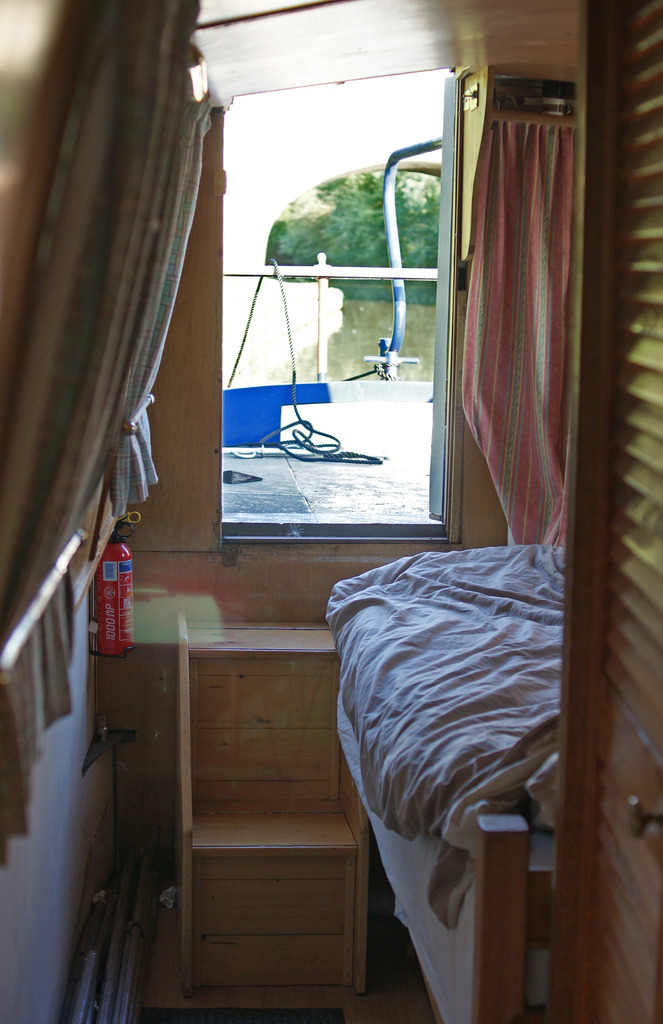

In [ ]:
from IPython.display import Image
Image("validation/968d0022f4b1d0dc.jpg")

In [ ]:
# Make a function to view images
def view_images(image_dict, random_image=True, n_images=1):
    plt.figure(figsize=(30,30))
    if random_image:
        for i, d in enumerate(random.sample(image_dict, n_images)):
            img=cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, :], 
                            metadata=val_metadata, 
                            scale=0.6)
            vis = visualizer.draw_dataset_dict(d)
            ax = plt.subplot(n_images, 1, i+1)
            plt.imshow(vis.get_image()[:, :, ::-1])
            plt.axis("off")

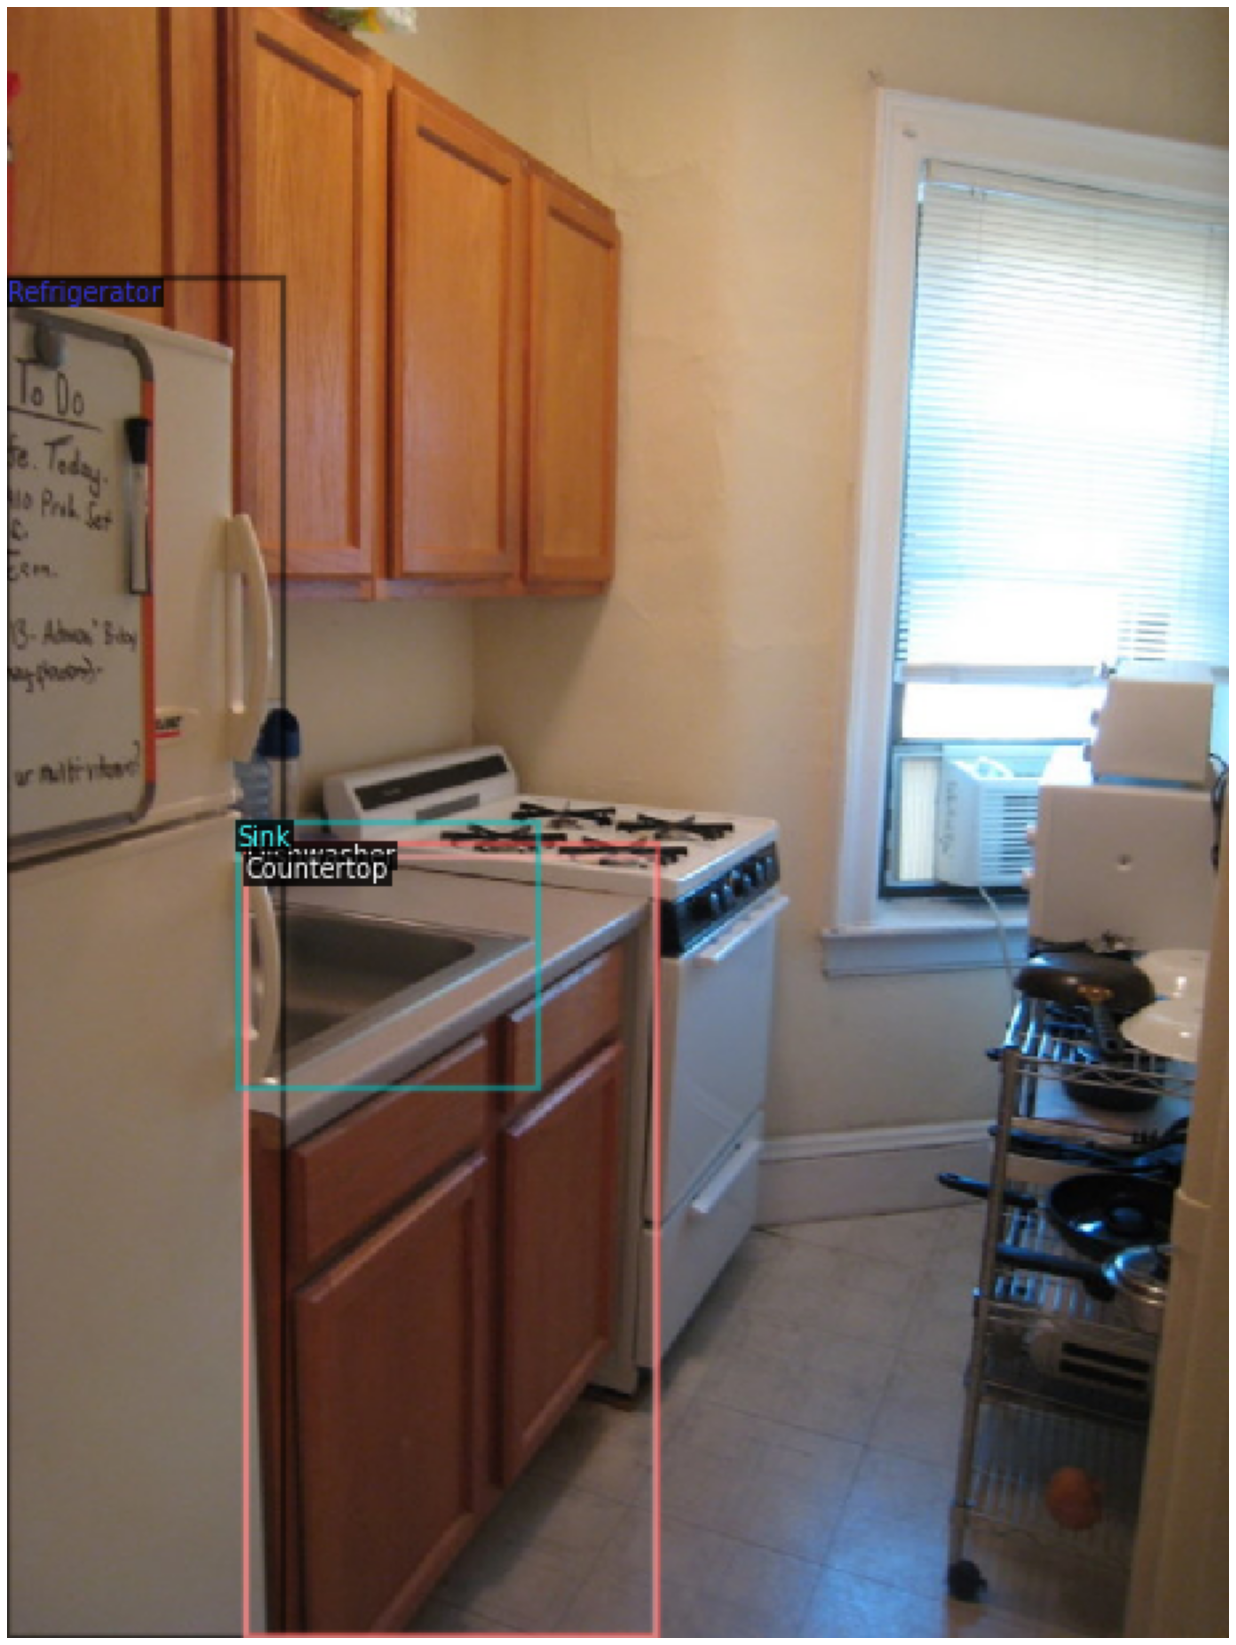

In [ ]:
view_images(val_img_dicts)

# TK: Could I turn this into a script? Instead of it being in a notebook?

In [ ]:
import csv
with open("validation-annotations-bbox.csv") as file:
    reader = csv.reader(file)   
reader

In [ ]:
import csv
with open("class-descriptions-boxable.csv") as file:
    reader = csv.reader(file)
    dict_list = {row[1]:row[0] for row in reader}
dict_list

{'Accordion': '/m/0mkg',
 'Adhesive tape': '/m/03m3vtv',
 'Aircraft': '/m/0k5j',
 'Airplane': '/m/0cmf2',
 'Alarm clock': '/m/046dlr',
 'Alpaca': '/m/0pcr',
 'Ambulance': '/m/012n7d',
 'Animal': '/m/0jbk',
 'Ant': '/m/0_k2',
 'Antelope': '/m/0czz2',
 'Apple': '/m/014j1m',
 'Armadillo': '/m/0xfy',
 'Artichoke': '/m/047v4b',
 'Asparagus': '/m/0cjs7',
 'Auto part': '/m/08dz3q',
 'Axe': '/m/0c2jj',
 'Backpack': '/m/01940j',
 'Bagel': '/m/01fb_0',
 'Baked goods': '/m/052lwg6',
 'Balance beam': '/m/0l3ms',
 'Ball': '/m/018xm',
 'Balloon': '/m/01j51',
 'Banana': '/m/09qck',
 'Band-aid': '/m/0j496',
 'Banjo': '/m/018j2',
 'Barge': '/m/01btn',
 'Barrel': '/m/02zn6n',
 'Baseball bat': '/m/03g8mr',
 'Baseball glove': '/m/03grzl',
 'Bat': '/m/01h44',
 'Bathroom accessory': '/m/0h8nr_l',
 'Bathroom cabinet': '/m/04y4h8h',
 'Bathtub': '/m/03dnzn',
 'Beaker': '/m/0d20w4',
 'Bear': '/m/01dws',
 'Bed': '/m/03ssj5',
 'Bee': '/m/01h3n',
 'Beehive': '/m/01gllr',
 'Beer': '/m/01599',
 'Beetle': '/m/020jm',